In [15]:
import arrow
import sys
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import chinese_calendar as calendar

from datetime import datetime
from tensorflow.python.keras.layers import Input, Dense, concatenate
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import LSTM
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.font_manager import FontManager, FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [197]:
def is_holiday(date):
    """
    判断是否是节假日
    """
    return calendar.is_holiday(date)

# 读取深圳市天气数据
weather_df = pd.read_csv('./data/深圳20230801-20230929天气数据.csv')
weather_df['date'] = pd.to_datetime(weather_df['时间'], utc=True, errors='ignore')
# utc => prc
prc_tz = pytz.timezone('Asia/Shanghai')
weather_df['date_prc'] = weather_df['date'].dt.tz_convert(prc_tz)
# 获取转换后时间的小时数
weather_df['日期'] = weather_df['date_prc'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
weather_df['小时'] = weather_df['date_prc'].dt.hour
weather_df['星期'] = weather_df['date_prc'].dt.weekday + 1
weather_df['是否节假日'] = weather_df['date_prc'].apply(lambda x: is_holiday(x)).astype(int)
weather_df

,城市,时间,温度,体感温度,露点温度,潮湿,降雨,降雨概率,preciptype,下雪,...,uvindex,severerisk,天气现象,icon,date,date_prc,日期,小时,星期,是否节假日
0,shenzhen,2023-07-31T00:00:00,29.0,35.3,25.7,82.30,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 00:00:00+00:00,2023-07-31 08:00:00+08:00,20230731,8,1,0
1,shenzhen,2023-07-31T01:00:00,28.6,33.9,25.2,81.75,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 01:00:00+00:00,2023-07-31 09:00:00+08:00,20230731,9,1,0
2,shenzhen,2023-07-31T02:00:00,26.7,30.2,25.5,93.42,0.506,100.0,rain,0,...,0,10,"Rain, Partially cloudy",rain,2023-07-31 02:00:00+00:00,2023-07-31 10:00:00+08:00,20230731,10,1,0
3,shenzhen,2023-07-31T03:00:00,27.6,32.4,25.6,88.65,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 03:00:00+00:00,2023-07-31 11:00:00+08:00,20230731,11,1,0
4,shenzhen,2023-07-31T04:00:00,27.6,32.1,25.2,86.43,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 04:00:00+00:00,2023-07-31 12:00:00+08:00,20230731,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,shenzhen,2023-09-29T19:00:00,27.0,28.1,18.9,61.22,0.000,28.6,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 19:00:00+00:00,2023-09-30 03:00:00+08:00,20230930,3,6,1
1460,shenzhen,2023-09-29T20:00:00,26.0,26.0,18.6,63.73,0.000,28.6,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 20:00:00+00:00,2023-09-30 04:00:00+08:00,20230930,4,6,1
1461,shenzhen,2023-09-29T21:00:00,25.7,25.7,18.4,63.94,0.000,38.1,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 21:00:00+00:00,2023-09-30 05:00:00+08:00,20230930,5,6,1
1462,shenzhen,2023-09-29T22:00:00,25.4,25.4,18.2,64.15,0.000,38.1,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 22:00:00+00:00,2023-09-30 06:00:00+08:00,20230930,6,6,1


In [198]:
# 增加台风标识
typhoon_before_hour = typhoon_after_hour = 4
typhoon_map = {
    1: '无台风',
    2: f'台风前{typhoon_before_hour}小时内',
    3: '台风中',
    4: f'台风后{typhoon_after_hour}小时内'
}

# 深圳近期台风时间
typhoon_date_map = {
    2: {
        "start_at": "2023-09-01 04:00:00",
        "end_at": "2023-09-01 08:00:00"
    },
    3:  {
        "start_at": "2023-09-01 09:00:00",
        "end_at": "2023-09-03 15:00:00"
    },
    4: {
        "start_at": "2023-09-03 16:00:00",
        "end_at": "2023-09-03 20:00:00"
    }
}

weather_df['台风'] = 1
for flag, typhoon_date in typhoon_date_map.items():
    start_at = typhoon_date['start_at']
    end_at = typhoon_date['end_at']
    # start_at = pd.to_datetime(start_at, utc=False)
    # end_at = pd.to_datetime(end_at, utc=False)
    start_at = arrow.get(start_at, 'YYYY-MM-DD HH:mm:ss', tzinfo='PRC').datetime
    end_at = arrow.get(end_at, 'YYYY-MM-DD HH:mm:ss', tzinfo='PRC').datetime
    weather_df['台风'] = weather_df['台风'].mask(
        (weather_df['date_prc'] >= start_at) & (weather_df['date_prc'] <= end_at),
        flag
    )

columns = ['日期', '小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '可见度']
weather_df = weather_df[columns]
# weather_df.to_csv('./data/深圳天气数据.csv')
weather_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度
0,20230731,8,1,0,29.0,35.3,0.000,9.7,1,10.0
1,20230731,9,1,0,28.6,33.9,0.000,11.2,1,10.0
2,20230731,10,1,0,26.7,30.2,0.506,3.8,1,23.9
3,20230731,11,1,0,27.6,32.4,0.000,13.8,1,10.0
4,20230731,12,1,0,27.6,32.1,0.000,9.3,1,9.6
...,...,...,...,...,...,...,...,...,...,...
1459,20230930,3,6,1,27.0,28.1,0.000,15.6,1,24.1
1460,20230930,4,6,1,26.0,26.0,0.000,16.9,1,24.1
1461,20230930,5,6,1,25.7,25.7,0.000,16.4,1,24.1
1462,20230930,6,6,1,25.4,25.4,0.000,16.0,1,24.1


In [200]:
dtype = {
    'city_code': 'str'
}
order_df = pd.read_csv('./data/线上-全部城市-20230913-订单.csv', dtype=dtype)
date_field = 'accepted_at'
order_df = order_df[order_df['city_code'] == '440300']
order_df['date'] = pd.to_datetime(order_df[date_field])  # 将日期转换为时间格式
# 这里不能用shipping_date，是utc时区
# order_df = order_df.rename(columns={'shipping_date': '日期'})
order_df['日期'] = order_df['date'].apply(lambda x: int(x.strftime('%Y%m%d')))
order_df['小时'] = order_df['date'].dt.hour
order_df['星期'] = order_df['date'].dt.weekday
order_df

,shipping_date,city_code,city_name,store_id,store_name,operator_id,operator_name,order_id,seller_order_id,distance,...,created_at,confirmed_at,accepted_at,arrived_at,pickup_at,done_at,date,日期,小时,星期
45,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8657267e2ce742b066c2d,64c8657267e2ce742b066c27,3467,...,2023-08-01T09:52:50.881000+08:00,2023-08-01T09:52:50.885000+08:00,2023-08-01T09:52:52.341000+08:00,2023-08-01T09:56:52.528000+08:00,2023-08-01T09:56:57.516000+08:00,2023-08-01T10:31:05.708000+08:00,2023-08-01 09:52:52.341000+08:00,20230801,9,1
46,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8666c67e2ce742b066c53,64c8666c67e2ce742b066c4d,2380,...,2023-08-01T09:57:00.163000+08:00,2023-08-01T09:57:00.168000+08:00,2023-08-01T09:57:01.179000+08:00,2023-08-01T09:57:48.157000+08:00,2023-08-01T09:59:31.654000+08:00,2023-08-01T10:16:45.537000+08:00,2023-08-01 09:57:01.179000+08:00,20230801,9,1
47,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71e80ec5d8f84e32b9344,钟彬,64c8673f67e2ce742b066c82,64c8673f67e2ce742b066c7c,17,...,2023-08-01T10:00:31.516000+08:00,2023-08-01T10:00:31.521000+08:00,2023-08-01T10:00:32.861000+08:00,2023-08-01T10:01:03.557000+08:00,2023-08-01T10:02:28.897000+08:00,2023-08-01T10:04:12.317000+08:00,2023-08-01 10:00:32.861000+08:00,20230801,10,1
48,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c750d82c3f486bbfec6af3,李焜湖,64c868fb67e2ce742b066ca3,64c868fb67e2ce742b066c9d,3691,...,2023-08-01T10:07:55.228000+08:00,2023-08-01T10:07:55.232000+08:00,2023-08-01T10:07:56.616000+08:00,2023-08-01T10:08:09.988000+08:00,2023-08-01T10:10:37.722000+08:00,2023-08-01T10:39:00.270000+08:00,2023-08-01 10:07:56.616000+08:00,20230801,10,1
49,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71d900f319a4d852ad78f,黄有元,64c86b9267e2ce742b066cc2,64c86b9267e2ce742b066cbc,931,...,2023-08-01T10:18:58.212000+08:00,2023-08-01T10:18:58.216000+08:00,2023-08-01T10:18:59.859000+08:00,2023-08-01T10:19:21.921000+08:00,2023-08-01T10:21:10.476000+08:00,2023-08-01T10:33:50.994000+08:00,2023-08-01 10:18:59.859000+08:00,20230801,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,65010ee5ca1b6d551e9b7c3c,65010ee5ca1b6d551e9b7c36,788,...,2023-09-13T09:22:45.600000+08:00,2023-09-13T09:22:45.605000+08:00,2023-09-13T09:27:53.293000+08:00,2023-09-13T09:30:57.842000+08:00,2023-09-13T09:37:17.553000+08:00,2023-09-13T09:42:38.661000+08:00,2023-09-13 09:27:53.293000+08:00,20230913,9,2
15081,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71a7c84aae8413855d884,李赟,6501102bca1b6d551e9b7c5b,6501102bca1b6d551e9b7c55,2264,...,2023-09-13T09:28:11.670000+08:00,2023-09-13T09:28:11.675000+08:00,2023-09-13T09:34:51.302000+08:00,2023-09-13T09:45:32.801000+08:00,2023-09-13T09:45:34.142000+08:00,2023-09-13T10:02:17.598000+08:00,2023-09-13 09:34:51.302000+08:00,20230913,9,2
15082,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,650111aeca1b6d551e9b7c74,650111aeca1b6d551e9b7c6e,723,...,2023-09-13T09:34:38.817000+08:00,2023-09-13T09:34:38.821000+08:00,2023-09-13T09:34:51.348000+08:00,2023-09-13T09:34:59.621000+08:00,2023-09-13T09:37:18.673000+08:00,2023-09-13T09:47:54.796000+08:00,2023-09-13 09:34:51.348000+08:00,20230913,9,2
15083,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64cc67d104d9a5e986f8efdc,赖阳武,6501150fca1b6d551e9b7c98,6501150fca1b6d551e9b7c92,2956,...,2023-09-13T09:49:03.342000+08:00,2023-09-13T09:49:03.346000+08:00,2023-09-13T09:49:04.649000+08:00,2023-09-13T09:53:20.411000+08:00,2023-09-13T10:11:39.768000+08:00,2023-09-13T10:24:28.646000+08:00,2023-09-13 09:49:04.649000+08:00,20230913,9,2


In [201]:
# 按小时统计单量
selected_order_df = order_df[(order_df['日期'] >= 20230802) & (order_df['日期'] < 20230913) ]
order_day_hour_df = selected_order_df.groupby(['日期', '小时']).size().reset_index(name='单量')
order_day_hour_df

,日期,小时,单量
0,20230802,0,24
1,20230802,1,7
2,20230802,2,7
3,20230802,3,4
4,20230802,4,4
...,...,...,...
984,20230912,19,22
985,20230912,20,18
986,20230912,21,25
987,20230912,22,37


In [202]:
order_day_df = order_df.groupby('日期').size().reset_index(name='单量')
order_day_df

,日期,单量
0,20230801,305
1,20230802,331
2,20230803,344
3,20230804,435
4,20230805,411
5,20230806,344
6,20230807,301
7,20230808,311
8,20230809,322
9,20230810,307


In [203]:
# 合并天气数据
df = order_day_hour_df.merge(weather_df, on=['日期', '小时'], how='inner')
df

,日期,小时,单量,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度
0,20230802,0,24,3,0,30.4,37.0,0.000,11.6,1,10.0
1,20230802,1,7,3,0,32.2,38.5,0.000,7.2,1,28.5
2,20230802,2,7,3,0,30.4,36.4,0.000,11.7,1,10.0
3,20230802,3,4,3,0,29.5,34.5,0.000,11.0,1,10.0
4,20230802,4,4,3,0,28.2,32.9,0.001,3.6,1,29.0
...,...,...,...,...,...,...,...,...,...,...,...
984,20230912,19,22,2,0,29.9,36.9,0.000,13.8,1,31.1
985,20230912,20,18,2,0,30.3,36.3,0.000,10.4,1,10.0
986,20230912,21,25,2,0,30.4,36.9,0.000,11.8,1,10.0
987,20230912,22,37,2,0,30.1,37.9,0.000,7.5,1,33.2


In [227]:
# 选取需要的特征列，并做数据归一化处理
feature_columns = ['小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '可见度']
feature_size = len(feature_columns)
predict_column = '单量'
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(df[feature_columns])
order_scaler = MinMaxScaler()
scaled_y = order_scaler.fit_transform(df[[predict_column]])

In [228]:
train_x = np.reshape(scaled_x, (scaled_x.shape[0], 1, scaled_x.shape[1]))
train_y = np.reshape(scaled_y, (scaled_y.shape[0], 1, scaled_y.shape[1]))

model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(1, feature_size)))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')
# 训练模型
model.fit(train_x, train_y, epochs=100, batch_size=10, verbose=1, workers=4, use_multiprocessing=True)

# 评估模型
# loss = model.evaluate(scaled_x, scaled_y)
# loss

Epoch 1/100
99/99 [==============================] - 5s 3ms/step - loss: 0.0301
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 13/100
99/99 [=================

In [221]:
# 预测结果
predict_df = weather_df[weather_df['日期'] >= 20230801]
predict_data = scaler.fit_transform(predict_df[feature_columns])
test_x = np.reshape(predict_data, (predict_data.shape[0], 1, predict_data.shape[1]))
predict_result = model.predict(test_x)
predict_result

# 预测结果反归一化
predict_order = order_scaler.inverse_transform(predict_result)
predict_order
predict_df.loc[:, ['预测单量']] = predict_order
predict_df

/var/folders/jg/g_sml8hs01z_489v147wbhkr0000gn/T/ipykernel_9340/1383081432.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df.loc[:, ['预测单量']] = predict_order


,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度,预测单量
16,20230801,0,2,0,29.6,35.8,0.0,20.9,1,7.6,5.713890
17,20230801,1,2,0,29.2,35.0,0.0,10.9,1,29.0,5.341363
18,20230801,2,2,0,30.4,36.6,0.0,20.1,1,10.0,7.099633
19,20230801,3,2,0,29.5,35.1,0.0,19.5,1,10.0,6.753346
20,20230801,4,2,0,27.7,32.1,0.0,7.4,1,29.0,6.127307
...,...,...,...,...,...,...,...,...,...,...,...
1459,20230930,3,6,1,27.0,28.1,0.0,15.6,1,24.1,7.817259
1460,20230930,4,6,1,26.0,26.0,0.0,16.9,1,24.1,8.375694
1461,20230930,5,6,1,25.7,25.7,0.0,16.4,1,24.1,9.126898
1462,20230930,6,6,1,25.4,25.4,0.0,16.0,1,24.1,9.917554


In [222]:
predict_hour_df = predict_df.merge(order_day_hour_df, how='left', on=['日期', '小时'])
predict_hour_df['单量'] = predict_hour_df['单量'].fillna(0)
predict_hour_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度,预测单量,单量
0,20230801,0,2,0,29.6,35.8,0.0,20.9,1,7.6,5.713890,0.0
1,20230801,1,2,0,29.2,35.0,0.0,10.9,1,29.0,5.341363,0.0
2,20230801,2,2,0,30.4,36.6,0.0,20.1,1,10.0,7.099633,0.0
3,20230801,3,2,0,29.5,35.1,0.0,19.5,1,10.0,6.753346,0.0
4,20230801,4,2,0,27.7,32.1,0.0,7.4,1,29.0,6.127307,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1443,20230930,3,6,1,27.0,28.1,0.0,15.6,1,24.1,7.817259,0.0
1444,20230930,4,6,1,26.0,26.0,0.0,16.9,1,24.1,8.375694,0.0
1445,20230930,5,6,1,25.7,25.7,0.0,16.4,1,24.1,9.126898,0.0
1446,20230930,6,6,1,25.4,25.4,0.0,16.0,1,24.1,9.917554,0.0


/var/folders/jg/g_sml8hs01z_489v147wbhkr0000gn/T/ipykernel_9340/2977373447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_hour_df['小时'] = predict_hour_df['小时'].astype(str)


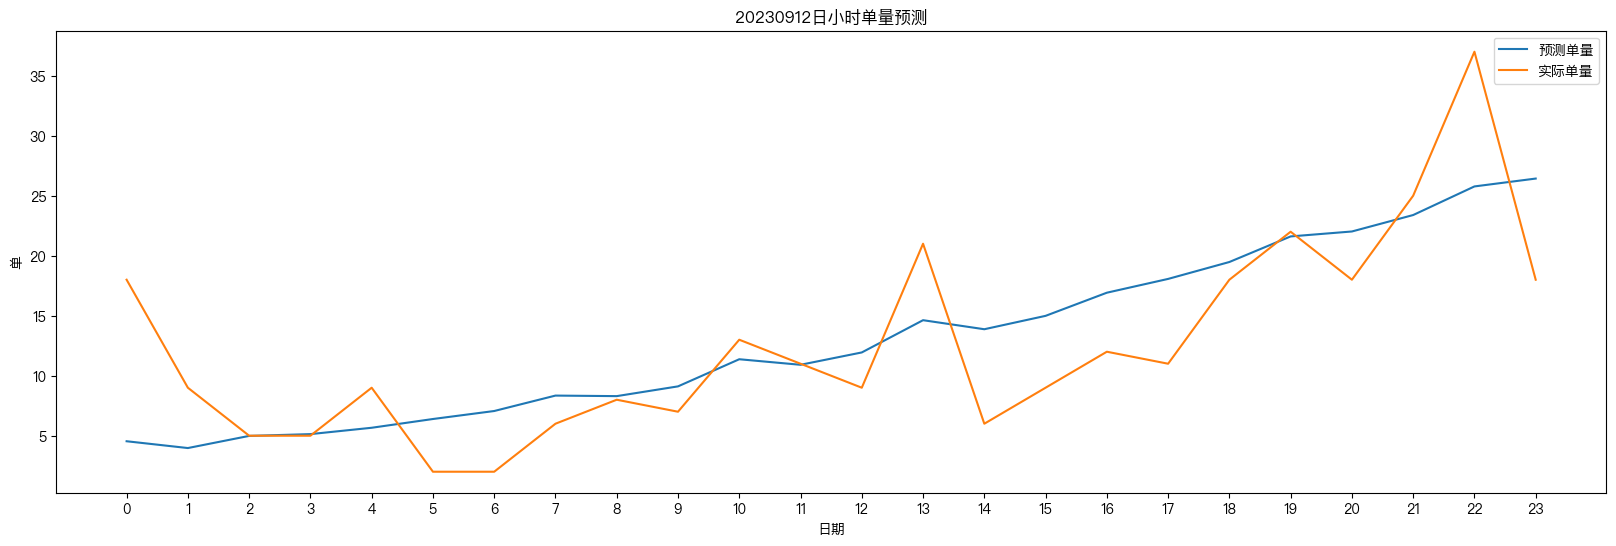

In [223]:
# 创建图形和子图
fig, ax = plt.subplots(figsize=(20, 6))
day = 20230912
predict_hour_df = predict_hour_df[predict_hour_df['日期'] == day]
predict_hour_df['小时'] = predict_hour_df['小时'].astype(str)
ax.plot(predict_hour_df['小时'], predict_hour_df['预测单量'], label='预测单量')
ax.plot(predict_hour_df['小时'], predict_hour_df['单量'], label='实际单量')
ax.legend()
ax.set_title(f'{20230912}日小时单量预测')
ax.set_xlabel('日期')
ax.set_ylabel('单')
plt.xticks(rotation=0)
plt.show()

In [224]:
# 按天合并单量
predict_day_df = predict_df.groupby('日期').agg({"预测单量": 'sum'})
predict_day_df = predict_day_df.merge(order_day_df, how='left', on='日期')
predict_day_df

,日期,预测单量,单量
0,20230801,325.108757,305.0
1,20230802,346.734640,331.0
2,20230803,368.490367,344.0
3,20230804,385.157677,435.0
4,20230805,363.713408,411.0
...,...,...,...
56,20230926,325.059554,NaN
57,20230927,343.170141,NaN
58,20230928,372.282410,NaN
59,20230929,361.108352,NaN


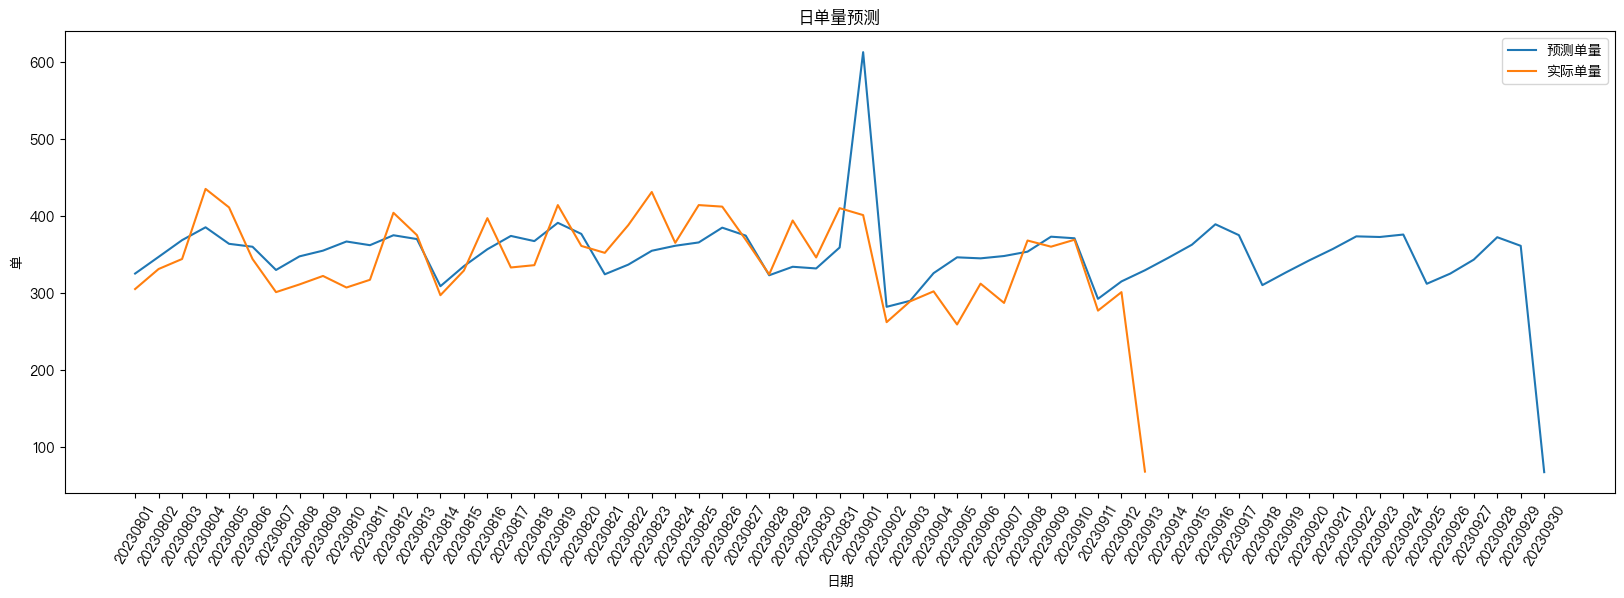

In [226]:
# 创建图形和子图
fig, ax = plt.subplots(figsize=(20, 6))
# 将日期转换为 datetime 对象
# predict_day_df['日期'] = pd.to_datetime(predict_day_df['日期'])
predict_day_df['日期'] = predict_day_df['日期'].astype(str)
ax.plot(predict_day_df['日期'], predict_day_df['预测单量'], label='预测单量')
ax.plot(predict_day_df['日期'], predict_day_df['单量'], label='实际单量')
ax.legend()
ax.set_title('日单量预测')
ax.set_xlabel('日期')
ax.set_ylabel('单')
plt.xticks(rotation=60)
plt.show()